## Imports

In [119]:
# Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats



## Preprocessing


In [120]:
# # Preprocessing
# # Load the data
# yulu_data_set = pd.read_csv('yulu_bike_sharing_dataset.csv')

# # # Filter rows where the column "weather" equals 4
# # weather_4_rows = yulu_data_set[yulu_data_set['weather'] == 4]

# # # Display the filtered rows
# # print(weather_4_rows)

# # Drop rows where the column "weather" equals 4
# #yulu_data_set = yulu_data_set[yulu_data_set['weather'] != 4]


# # Split the 'datetime' column into 'date' and 'time' columns
# yulu_data_set[['date', 'time']] = yulu_data_set['datetime'].str.split(' ', expand=True)
# yulu_data_set = yulu_data_set.drop(columns=['datetime'])

# # Specify the names of categorical and numerical columns
# categorical_columns = ['season', 'holiday', 'workingday', 'weather'] 
# numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed'] 
# target_column = 'count' 

# # Creating a column transformer for handling both numerical and categorical variables
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_columns),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
#     ])


In [121]:
# Preprocessing
# Load the data
yulu_data_set = pd.read_csv('yulu_bike_sharing_dataset.csv')

# # Filter rows where the column "weather" equals 4
# weather_4_rows = yulu_data_set[yulu_data_set['weather'] == 4]

# # Display the filtered rows
# print(weather_4_rows)

# Drop rows where the column "weather" equals 4
yulu_data_set = yulu_data_set[yulu_data_set['weather'] != 4]


# Split the 'datetime' column into 'date' and 'time' columns
yulu_data_set[['date', 'time']] = yulu_data_set['datetime'].str.split(' ', expand=True)
yulu_data_set = yulu_data_set.drop(columns=['datetime'])

# Extract features from 'date' column
yulu_data_set['year'] = pd.to_datetime(yulu_data_set['date']).dt.year
yulu_data_set['month'] = pd.to_datetime(yulu_data_set['date']).dt.month
yulu_data_set['day'] = pd.to_datetime(yulu_data_set['date']).dt.day
yulu_data_set['day_of_week'] = pd.to_datetime(yulu_data_set['date']).dt.dayofweek

# Extract hour from 'time' column
yulu_data_set['hour'] = pd.to_datetime(yulu_data_set['time'], format='%H:%M:%S').dt.hour

# # Apply cyclic transformation to 'hour'
# import numpy as np

# yulu_data_set['hour_sin'] = np.sin(2 * np.pi * yulu_data_set['hour'] / 24)
# yulu_data_set['hour_cos'] = np.cos(2 * np.pi * yulu_data_set['hour'] / 24)

# Drop original 'date' and 'time' columns as they are no longer needed
yulu_data_set = yulu_data_set.drop(columns=['date', 'time'])

# Specify the names of categorical and numerical columns
categorical_columns = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'day_of_week'] 
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour'] 
#numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour_sin', 'hour_cos'] 
target_column = 'count' 

# Creating a column transformer for handling both numerical and categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])


In [122]:
print("Data Info")
print(yulu_data_set.info())

Data Info
<class 'pandas.core.frame.DataFrame'>
Index: 10885 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       10885 non-null  int64  
 1   holiday      10885 non-null  int64  
 2   workingday   10885 non-null  int64  
 3   weather      10885 non-null  int64  
 4   temp         10885 non-null  float64
 5   atemp        10885 non-null  float64
 6   humidity     10885 non-null  int64  
 7   windspeed    10885 non-null  float64
 8   casual       10885 non-null  int64  
 9   registered   10885 non-null  int64  
 10  count        10885 non-null  int64  
 11  year         10885 non-null  int32  
 12  month        10885 non-null  int32  
 13  day          10885 non-null  int32  
 14  day_of_week  10885 non-null  int32  
 15  hour         10885 non-null  int32  
dtypes: float64(3), int32(5), int64(8)
memory usage: 1.2 MB
None


## Outlier Detection and Removal

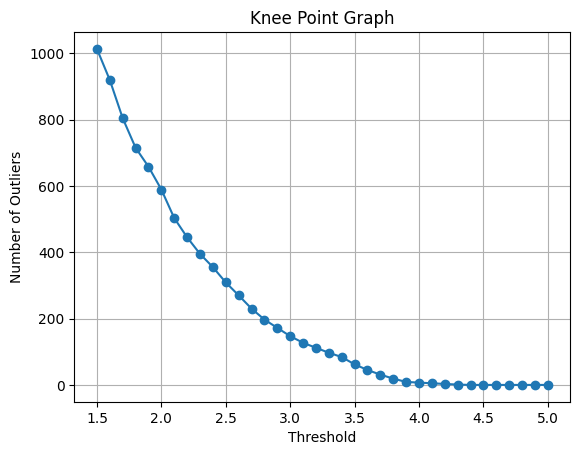

In [123]:
# Initialize lists to store results
# thresholds is a list of values from 1.5 to 5.0 with a step of 0.1
thresholds = np.arange(1.5, 5.1, 0.1)
num_outliers_list = []  # List to store the number of outliers for each threshold
threshold_list = []  # List to store the threshold values

# Loop through different thresholds
for i in thresholds:
    # Apply z-score outlier detection
    # z_scores is a list of z-scores for each data point in the 'salary_in_usd' column
    z_scores = np.abs(stats.zscore(yulu_data_set['count']))
    # outliers is a list of indices where the z-score is greater than the threshold
    outliers = np.where((z_scores > i) | (z_scores < -i))[0]

    # Store results
    # Number of outliers for the current threshold
    num_outliers = len(outliers)
    # Append the number of outliers to the list
    num_outliers_list.append(num_outliers)
    threshold_list.append(i)  # Append the current threshold to the list

# Plot knee point graph
plt.plot(threshold_list, num_outliers_list, marker='o', linestyle='-')
plt.title('Knee Point Graph')
plt.ylabel('Number of Outliers')
plt.xlabel('Threshold')
plt.grid(True)
plt.show()

In [124]:
# Outlier detection
# Set the threshold for outlier detection
threshold = 3.5

# Calculate the z-scores for each data point in the 'count' column
z_scores = stats.zscore(yulu_data_set['count'])

# Filter the data: only keep data points where the z-score is less than the threshold and greater than the negative threshold
data_without_outliers = yulu_data_set[(z_scores < threshold) & (z_scores > -threshold)]

# Print the number of outliers removed
print(f"Outliers removed: {len(yulu_data_set) - len(data_without_outliers)}")

Outliers removed: 62


## Train-test split

In [125]:
# # Train Test split
# # Separating the target variable
# X = data_without_outliers.drop(columns=[target_column])
# y = data_without_outliers[target_column]

# # Splitting data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = data_without_outliers['count'] )


In [126]:
# Separate features and target
X = data_without_outliers
y = data_without_outliers['count']

# Convert target to a sorted NumPy array
sorted_y = np.sort(y)

# Determine the bin edges such that each bin has at least six entries
min_bin_size = 2
bin_edges = [sorted_y[0]]
for i in range(min_bin_size, len(sorted_y), min_bin_size):
    bin_edges.append(sorted_y[i-1])
bin_edges.append(sorted_y[-1])

# Remove duplicates and sort the bin edges
bin_edges = np.unique(bin_edges)

# Function to calculate bin counts consistently
def calculate_bin_counts(sorted_values, bin_edges):
    binned_values = pd.cut(sorted_values, bins=bin_edges, include_lowest=True)
    return binned_values.value_counts().sort_index()

# Ensure that each bin has at least min_bin_size entries by adjusting bins
bins_valid = False
while not bins_valid:
    bin_counts = calculate_bin_counts(sorted_y, bin_edges)
    if np.all(bin_counts >= min_bin_size):
        bins_valid = True
    else:
        # Merge bins with fewer than min_bin_size items
        invalid_bins = np.where(bin_counts < min_bin_size)[0]
        for idx in invalid_bins:
            if idx > 0:
                bin_edges = np.delete(bin_edges, idx)
                break

# Perform a final check and merge any bins with fewer than min_bin_size items
final_bin_counts = calculate_bin_counts(sorted_y, bin_edges)
while np.any(final_bin_counts < min_bin_size):
    invalid_bins = np.where(final_bin_counts < min_bin_size)[0]
    for idx in invalid_bins:
        if idx > 0:
            bin_edges = np.delete(bin_edges, idx)
            break
    final_bin_counts = calculate_bin_counts(sorted_y, bin_edges)

# Create bin labels
bin_labels = np.arange(1, len(bin_edges))  # Using indexes as labels

# Bin the values for stratification purposes
y_binned = pd.cut(y, bins=bin_edges, labels=bin_labels, include_lowest=True)

# Check that binning went as planned
print('Unique values in y:', y.nunique())
print('Unique values in y_binned:', y_binned.nunique())

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

# Overwrite categories with continious variable
y_test = X_test['count'].values
y_train = X_train['count'].values

# Dropping the real target from training
X_train = X_train.drop(columns='count')
X_test = X_test.drop(columns='count')

# Check if it worked out
# print(X_test)
# print(X_train)
# print(y_test)
# print(y_train)



Unique values in y: 772
Unique values in y_binned: 702


## Feature Selection

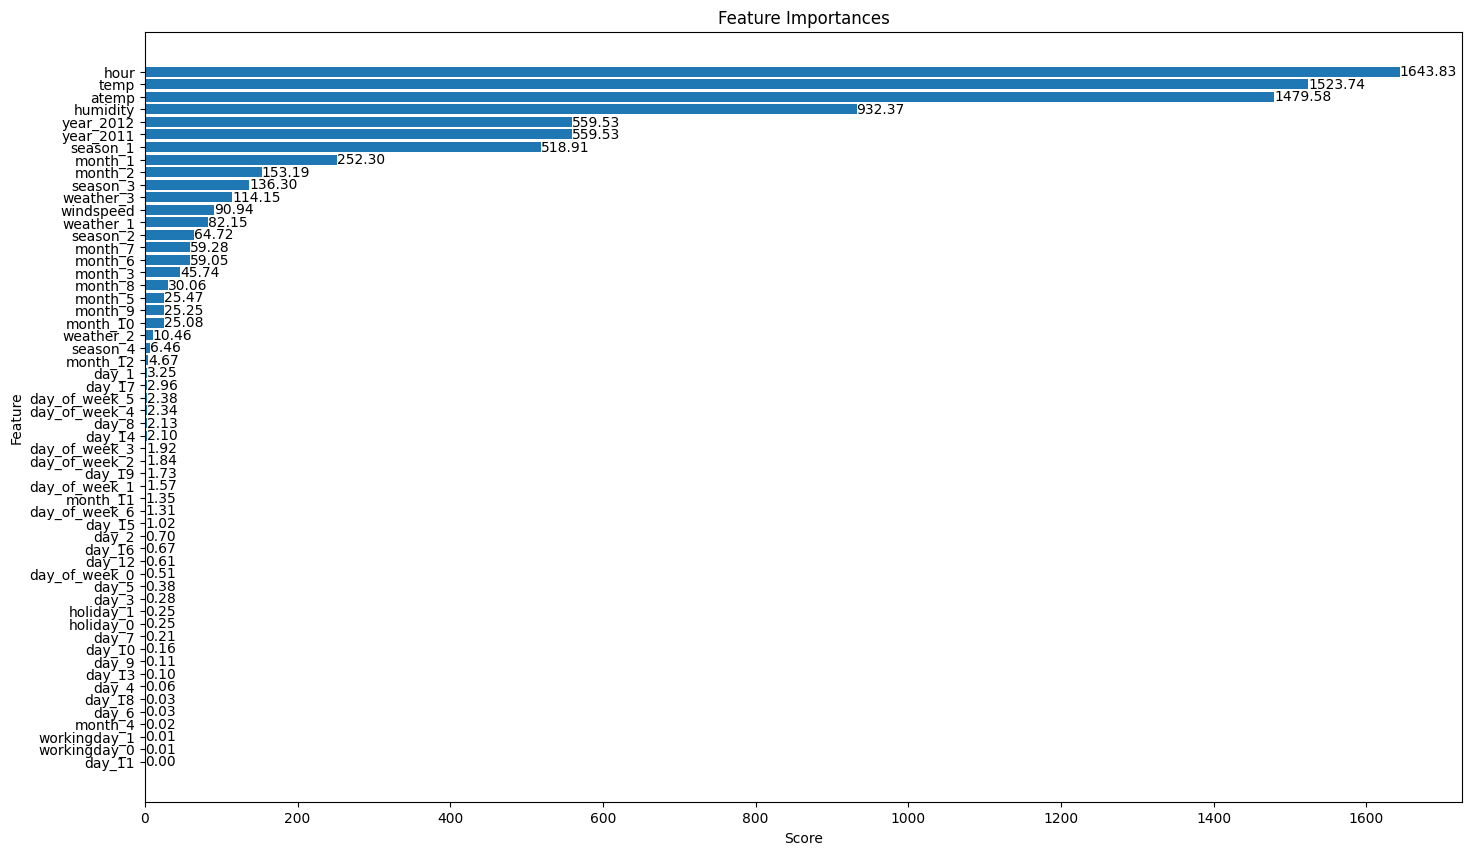

In [127]:
# Feature selection
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Apply SelectKBest with f_regression
k = 10  # Number of top features to select, adjust as needed
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)

# Get feature names
num_features = numerical_columns
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_features = list(num_features) + list(cat_features)

# Get the scores of the features
feature_scores = selector.scores_

# Create a DataFrame for visualization
feature_scores_df = pd.DataFrame({'Feature': all_features, 'Score': feature_scores})

# Sort the DataFrame by score
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Plot the feature importances with individual scores
plt.figure(figsize=(17, 10))
bars = plt.barh(feature_scores_df['Feature'], feature_scores_df['Score'])
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()

# Add the scores as text on the bars
for bar, score in zip(bars, feature_scores_df['Score']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

## Feature Selection by Column

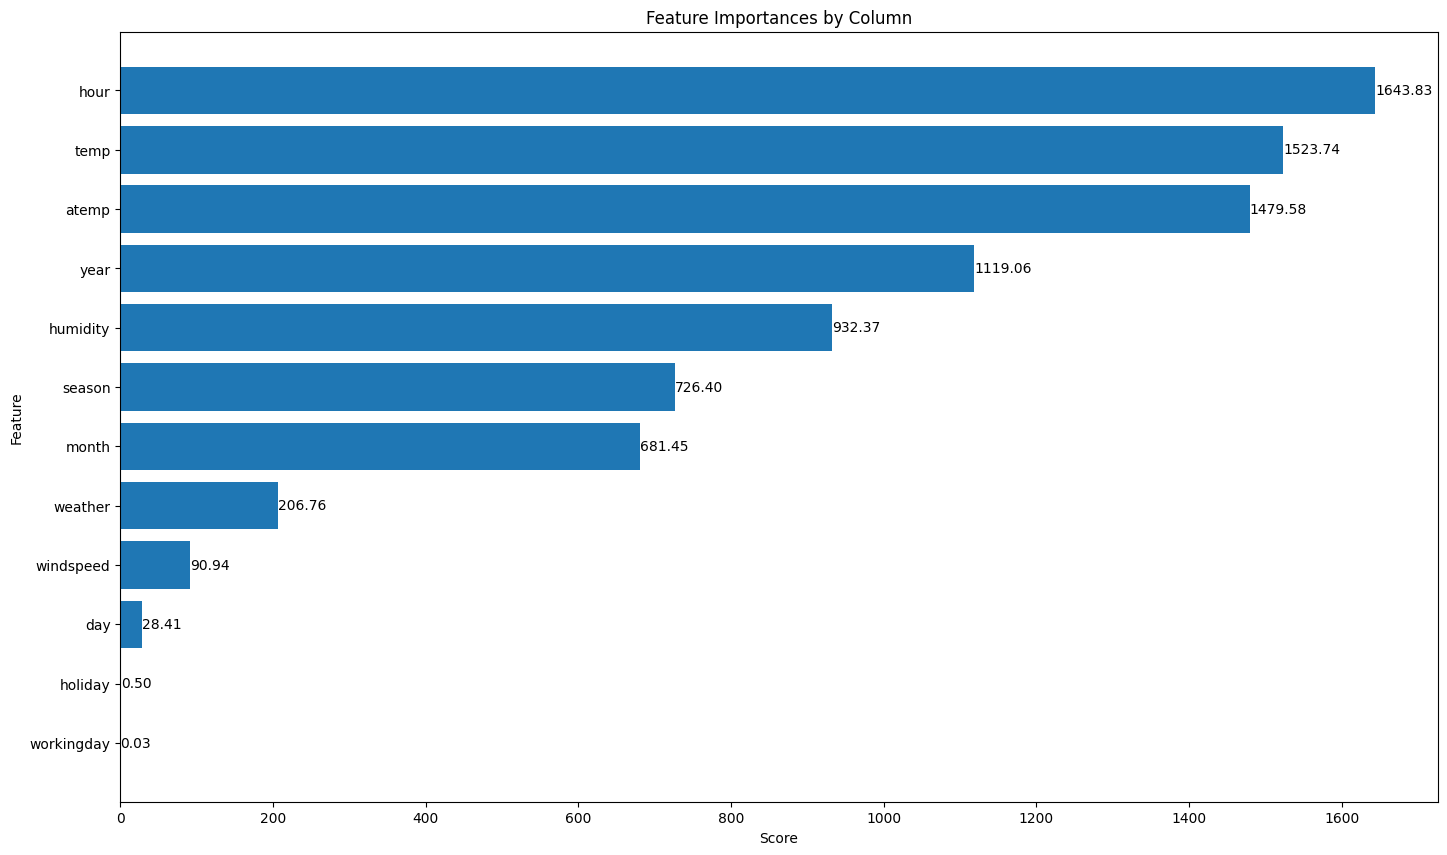

In [128]:
# Feature selection by column
# Aggregate the scores for the original categorical columns
categorical_scores = {}
for feature in cat_features:
    original_col = feature.split('_')[0]
    if original_col in categorical_scores:
        categorical_scores[original_col] += feature_scores[all_features.index(feature)]
    else:
        categorical_scores[original_col] = feature_scores[all_features.index(feature)]

# Combine numerical and aggregated categorical scores
final_feature_scores = {feature: score for feature, score in zip(num_features, feature_scores[:len(num_features)])}
final_feature_scores.update(categorical_scores)

# Convert to DataFrame for plotting
final_feature_scores_df = pd.DataFrame(list(final_feature_scores.items()), columns=['Feature', 'Score'])
final_feature_scores_df = final_feature_scores_df.sort_values(by='Score', ascending=False)

# Plot the feature importances by column with individual scores
plt.figure(figsize=(17, 10))
bars = plt.barh(final_feature_scores_df['Feature'], final_feature_scores_df['Score'])
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importances by Column')
plt.gca().invert_yaxis()

# Add the scores as text on the bars
for bar, score in zip(bars, final_feature_scores_df['Score']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

## Linear Regression

In [129]:
# Define the range of k values
k_values = [ 10 , 15, 20, 25, 30, 'all'] 

# Hyperparameter tuning for Linear Regression including k
# Creating a pipeline with preprocessing and Linear Regression
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression)),
    ('regressor', LinearRegression())
])

# Define parameter grid for Linear Regression including k
param_grid_linear = {
    'selector__k': k_values
}

# Use GridSearchCV for hyperparameter tuning
grid_search_linear = GridSearchCV(linear_model, param_grid_linear, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_linear.fit(X_train, y_train)

# Best parameters and best score
print("Linear Regression Best Parameters:", grid_search_linear.best_params_)
print("Linear Regression Best Cross-validated MSE:", -grid_search_linear.best_score_)

# Fit the best model on training data
best_linear_model = grid_search_linear.best_estimator_
best_linear_model.fit(X_train, y_train)

# Predictions
y_pred_linear = best_linear_model.predict(X_test)

# Metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression Mean Squared Error (MSE):", mse_linear)
print("Linear Regression Mean Absolute Error (MAE):", mae_linear)
print("Linear Regression R-squared:", r2_linear)


Linear Regression Best Parameters: {'selector__k': 20}
Linear Regression Best Cross-validated MSE: 18601.093641724812
Linear Regression Mean Squared Error (MSE): 17118.20568386505
Linear Regression Mean Absolute Error (MAE): 100.1233060623157
Linear Regression R-squared: 0.4166859366943665


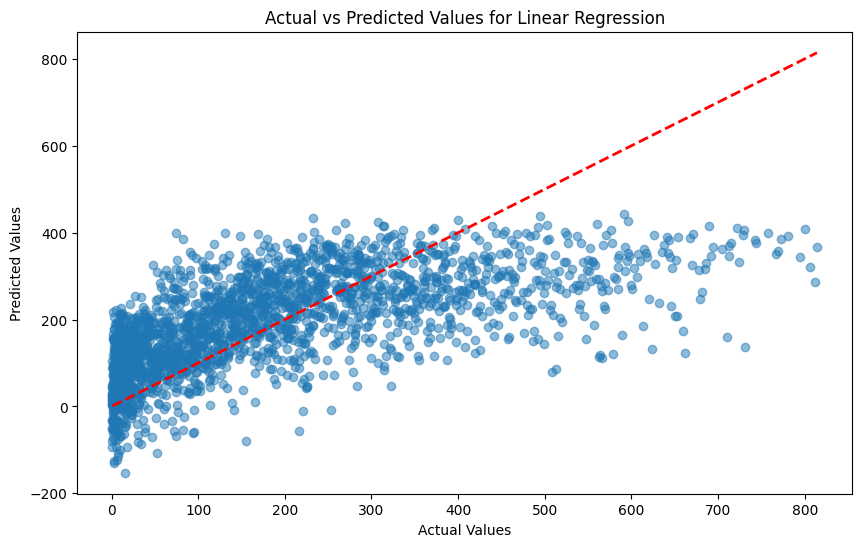

In [130]:
# Plot a graph to see actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Linear Regression')
plt.show()

## Random Forest Regressor

In [135]:
# Hyperparameter tuning for RandomForestRegressor

#How many features are used
k_values = [ 10 , 12 , 14] 

# Creating a pipeline with preprocessing and Random Forest regressor
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression)),
    ('regressor', RandomForestRegressor())
])

# Define parameter grid for RandomForest
param_grid = {
    'selector__k': k_values,
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [None, 15 , 10]
}


# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Random Forest Best Parameters:", grid_search.best_params_)
print("Random Forest Best Cross-validated MSE:", -grid_search.best_score_)

# Fit the best model on training data
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error (MSE):", mse_rf)
print("Random Forest Mean Absolute Error (MAE):", mae_rf)
print("Random Forest R-squared:", r2_rf)


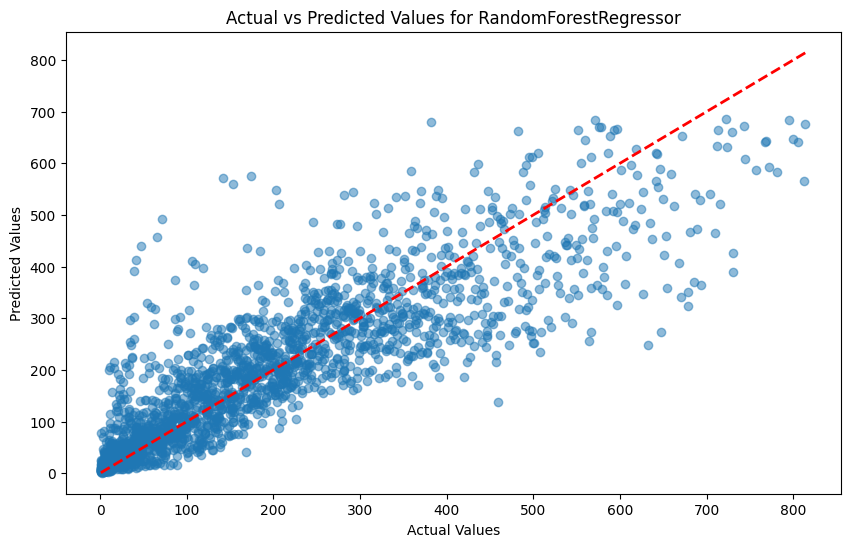

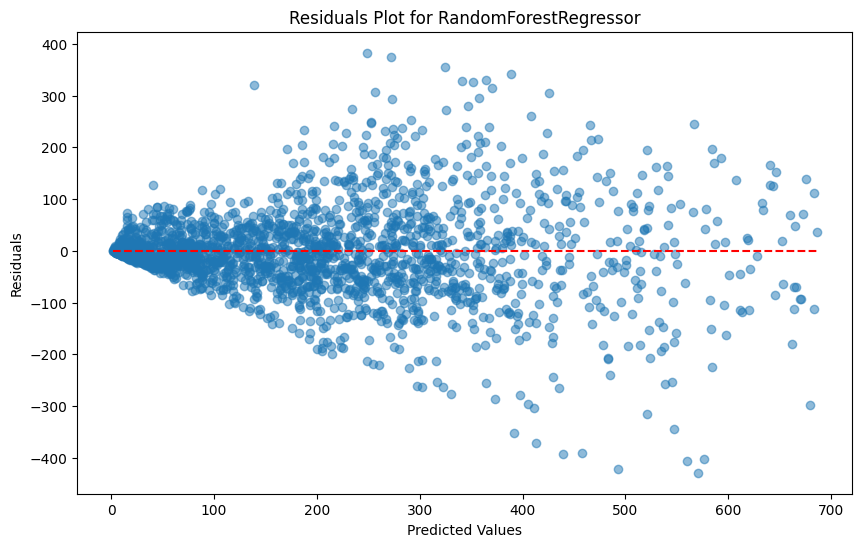

In [132]:
# Plot a graph to see actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for RandomForestRegressor')
plt.show()

#Plotting Residuals (differences between predicted and actual values)
residuals = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_rf.min(), xmax=y_pred_rf.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot for RandomForestRegressor')
plt.show()

## KNN Regressor

In [133]:
#How many features are used
k_values = [ 10 , 12, 25, 25, 30, 'all'] 

# Preprocessing, feature selection, and Model Training (KNeighborsRegressor)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('select_k_best', SelectKBest(score_func=f_regression)),
    ('regressor', KNeighborsRegressor())
])

# Define the grid of hyperparameters to search
parameters = {
    'select_k_best__k': k_values,
    'regressor__n_neighbors' : [3, 5, 8, 10]
}

# Instantiating GridSearchCV
grid_search_KNN = GridSearchCV(pipeline, parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


# Fit the model on the training data
grid_search_KNN.fit(X_train, y_train)


# Predict
y_pred_KNN = grid_search_KNN.predict(X_test)

# Best parameters used
print(" KNN-Regression Best Parameters:", grid_search_KNN.best_params_)

# Print performance metrics
print("KNN Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_KNN))
print("KNN Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_KNN))
print("KNN R-squared:", r2_score(y_test, y_pred_KNN))

 KNN-Regression Best Parameters: {'regressor__n_neighbors': 8, 'select_k_best__k': 10}
KNN Mean Squared Error (MSE): 8837.026284642032
KNN Mean Absolute Error (MAE): 64.30923787528869
KNN R-squared: 0.6988725451235869


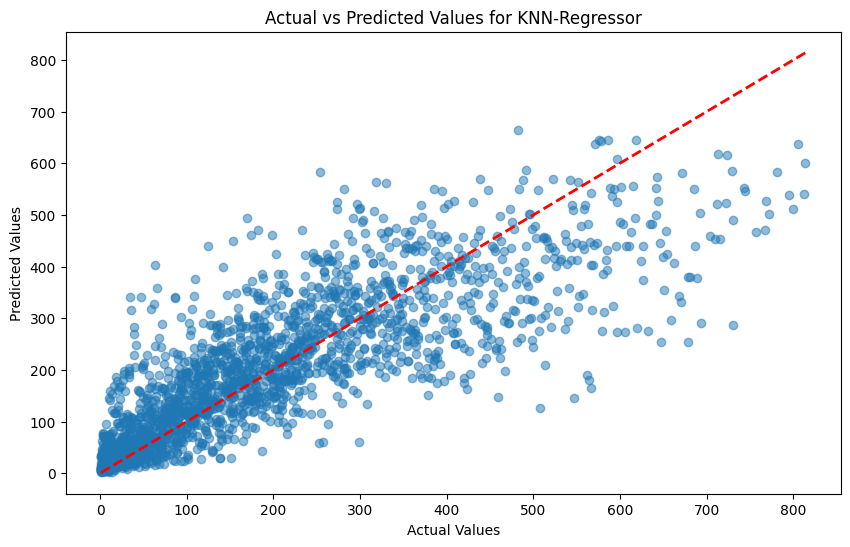

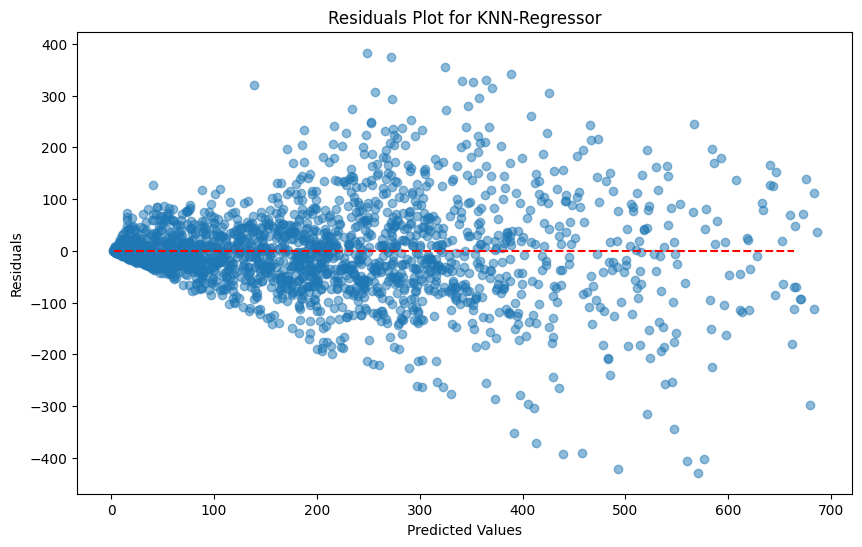

In [134]:
# Plot a graph to see actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_KNN, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for KNN-Regressor')
plt.show()

#Plotting Residuals (differences between predicted and actual values)
residuals = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_KNN.min(), xmax=y_pred_KNN.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot for KNN-Regressor')
plt.show()